# Data Cleaning and Preprocessing of Dataset

**Loading the dataset**

In [1]:
import pandas as pd
df = pd.read_csv('hotel_reviews.csv')
df.shape

(515738, 17)

**The dataset contains 5,15,000+ datapoints and 17 Features. We will get rid of the unnecessary features which do not contain much information**

In [ ]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["is_bad_review"] = df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
reviews_df = df[["review", "is_bad_review"]]

In [2]:
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No real complaints the hotel was great great ...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


**Analyzing the skewness of dependent variable**

<AxesSubplot:xlabel='is_bad_review', ylabel='count'>

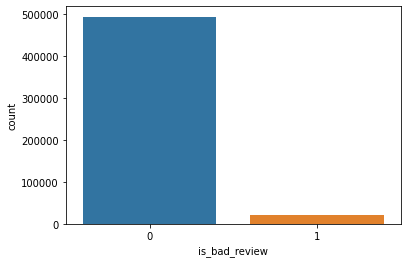

In [7]:
import seaborn as sns
sns.countplot(x = reviews_df['is_bad_review'])

**Upon close inspection, we found that the dependent variable is highly skewed, thus we will use the Random Undersampling Technqiue to remove the Majority Class Datapoints and balance our dataset**

In [9]:
count = 0
for i in reviews_df['is_bad_review']:
    if i==1:
        count+=1
count

22281

In [10]:
indexes = []
count = 0
pos_rev = 32719
for i in range(reviews_df.shape[0]):
    
    if reviews_df['is_bad_review'][i] == 0:
        if not (count < pos_rev):
            indexes.append(i)
        else:
            count+=1

In [ ]:
reviews_df.drop(index = indexes, axis = 0, inplace = True)

<AxesSubplot:xlabel='is_bad_review', ylabel='count'>

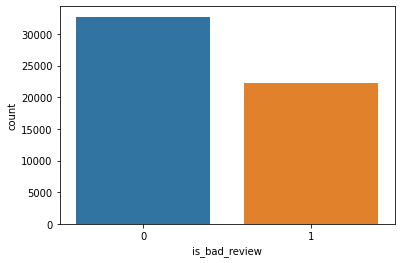

In [13]:
import seaborn as sns
sns.countplot(x = reviews_df['is_bad_review'])

**Our dataset is not skewed now**

In [ ]:
reviews_df.to_csv("data_max.csv", index = False)

In [12]:
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No real complaints the hotel was great great ...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


**Creating a seperate test dataset for model evaluation in the future**

In [14]:
from sklearn.model_selection import train_test_split
label = "is_bad_review"
ignore_cols = [label]
features = [c for c in reviews_df.columns if c not in ignore_cols]

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size=0.2, random_state=42)

In [15]:
X_test['is_bad_review'] = y_test

In [15]:
X_test.to_csv("test.csv", index = False)

In [16]:
X_train[label] = y_train
reviews_df = X_train

In [17]:
reviews_df.head()

,review,is_bad_review
24725,The hotel facilities and location was excelle...,0
65,Not being told a hedkandi night was across fr...,0
460707,Deposit taken too much money out of my account,1
81869,The room was tiny and gloomy and bore no rese...,1
24397,Fantastic hotel We can t wait to go back Room...,0


**The reviews in the dataset need to be preprocessed to remove stopwords, punctuations, etc. before converting them into vectors.
This will be done with the help of nltk library**

In [ ]:
import nltk

from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = str(text).lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

reviews_df["review_clean"] = reviews_df["review"]
reviews_df["review_clean"] = reviews_df["review_clean"].apply(lambda x: clean_text(x))

**The clean review is added as an attribute in the dataset which will be further used for vectorization**

In [19]:
reviews_df.head()

,review,is_bad_review,review_clean
24725,The hotel facilities and location was excelle...,0,hotel facility location excellent handy tube t...
65,Not being told a hedkandi night was across fr...,0,told hedkandi night across room leave sleep ro...
460707,Deposit taken too much money out of my account,1,deposit take much money account
81869,The room was tiny and gloomy and bore no rese...,1,room tiny gloomy bore resemblance website cons...
24397,Fantastic hotel We can t wait to go back Room...,0,fantastic hotel wait go back room lovely spaci...


# Feature Selection and Feature Extraction

**We will now use NLTK Vader Library which would give a polarity score to the original review based on the words present in the review. These features would help in the training of the model**

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"]
reviews_df["sentiments"] = reviews_df["sentiments"].apply(lambda x: sid.polarity_scores(str(x)))

In [21]:
reviews_df["neg"] = reviews_df["sentiments"]
reviews_df["neg"] = reviews_df["neg"].apply(lambda x: x['neg'])
reviews_df["pos"] = reviews_df["sentiments"]
reviews_df["pos"] = reviews_df["pos"].apply(lambda x: x['pos'])
reviews_df["neu"] = reviews_df["sentiments"]
reviews_df["neu"] = reviews_df["neu"].apply(lambda x: x['neu'])
reviews_df["compound"] = reviews_df["sentiments"]
reviews_df["compound"] = reviews_df["compound"].apply(lambda x: x['compound'])

In [22]:
reviews_df.drop('sentiments', axis = 1, inplace = True)

**This is the updated dataset**

In [23]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,pos,neu,compound
24725,The hotel facilities and location was excelle...,0,hotel facility location excellent handy tube t...,0.000,0.408,0.592,0.9300
65,Not being told a hedkandi night was across fr...,0,told hedkandi night across room leave sleep ro...,0.118,0.157,0.725,0.4391
460707,Deposit taken too much money out of my account,1,deposit take much money account,0.000,0.000,1.000,0.0000
81869,The room was tiny and gloomy and bore no rese...,1,room tiny gloomy bore resemblance website cons...,0.148,0.000,0.852,-0.9144
24397,Fantastic hotel We can t wait to go back Room...,0,fantastic hotel wait go back room lovely spaci...,0.000,0.340,0.660,0.9312


**We beleive that the number of charachters and the number of words in the review can act as important information to classify review into a positive or a negative review**

In [24]:
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(str(x)))
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(str(x).split(" ")))

In [25]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,pos,neu,compound,nb_chars,nb_words
24725,The hotel facilities and location was excelle...,0,hotel facility location excellent handy tube t...,0.000,0.408,0.592,0.9300,161,27
65,Not being told a hedkandi night was across fr...,0,told hedkandi night across room leave sleep ro...,0.118,0.157,0.725,0.4391,231,42
460707,Deposit taken too much money out of my account,1,deposit take much money account,0.000,0.000,1.000,0.0000,47,10
81869,The room was tiny and gloomy and bore no rese...,1,room tiny gloomy bore resemblance website cons...,0.148,0.000,0.852,-0.9144,543,109
24397,Fantastic hotel We can t wait to go back Room...,0,fantastic hotel wait go back room lovely spaci...,0.000,0.340,0.660,0.9312,183,35


**We will now use the famous TF-IDF technique for text vectorization. This technique has many advantages over the traditional Bag of Words**

**We will also use a Feature Selection technique while generating the vectors, we will only consider those words which occur atleast 10 times in the corpus. This allows us to not use Wrapper and Filter Techniques for Feature Selection in TF-IDF vectors**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

**This is our final dataset**

In [27]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,pos,neu,compound,nb_chars,nb_words,word_abandon,...,word_yet,word_yo,word_yoghurt,word_yogurt,word_young,word_youth,word_yr,word_yummy,word_zero,word_zone
24725,The hotel facilities and location was excelle...,0,hotel facility location excellent handy tube t...,0.000,0.408,0.592,0.9300,161,27,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,Not being told a hedkandi night was across fr...,0,told hedkandi night across room leave sleep ro...,0.118,0.157,0.725,0.4391,231,42,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460707,Deposit taken too much money out of my account,1,deposit take much money account,0.000,0.000,1.000,0.0000,47,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81869,The room was tiny and gloomy and bore no rese...,1,room tiny gloomy bore resemblance website cons...,0.148,0.000,0.852,-0.9144,543,109,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24397,Fantastic hotel We can t wait to go back Room...,0,fantastic hotel wait go back room lovely spaci...,0.000,0.340,0.660,0.9312,183,35,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
reviews_df.shape

(44000, 4009)

**Saving our TF-IDF vector for preprocessing of test dataset**

In [45]:
import joblib
joblib.dump(tfidf, 'tfidf.pkl') 

['tfidf.pkl']

**Saving our clean dataset**

In [7]:
reviews_df.to_csv("preprocessed_data_max.csv", index = False)

**We have also created a Python Script for the preprocessing of the test dataset following the same steps we did for the training dataset**